* 1 : Data Prepare and loading
* 2 : Build the model
* 3 : Fitting the model to the data
* 4 : Make predictions and evaluating (inference)
* 5 : Save and loading
* 6 : Putting all togather

# Import Libraries

In [227]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print('Torch version: ', torch.__version__)

Torch version:  2.2.1+cu121


# Data Preparing and Loading

In [228]:
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [229]:
X[:10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

In [230]:
y[:10]

tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])

In [231]:
print("X length: ", len(X))
print("y Length: ", len(y))

X length:  50
y Length:  50


#### Splitting data into training and testing

In [232]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [233]:
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

#### Visualize the data

In [234]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
    Plot training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # plot training data
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot test data
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  # are there predictions
  if predictions is not None:

    # plot the predictions if they exists
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  plt.legend(prop={'size': 14});

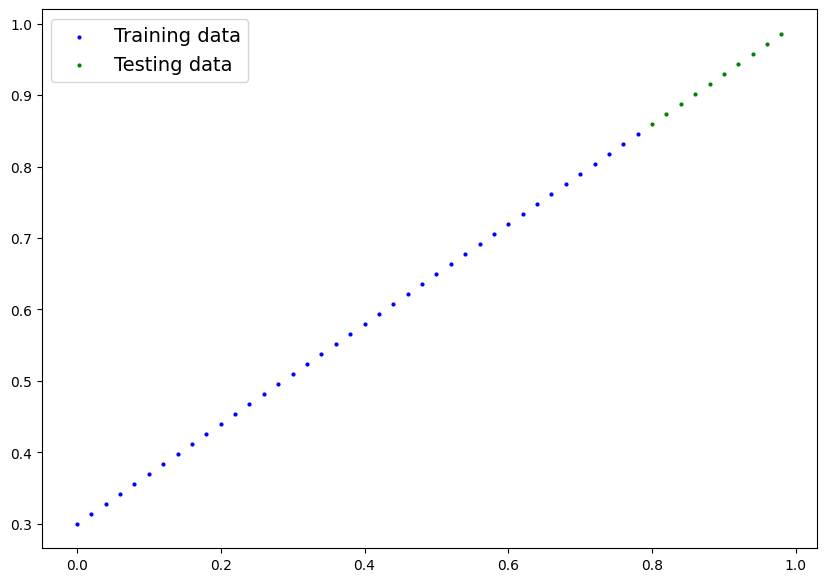

In [235]:
plot_predictions()

# Build the model

In [236]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [237]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

model_0

LinearRegressionModel()

In [238]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [239]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [240]:
weight, bias

(0.7, 0.3)

#### Making predictions using torch.inference_mode()

In [241]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [242]:
df = pd.DataFrame({
    'X_test':X_test.squeeze(),
    'Y_test':y_test.squeeze(),
    'y_preds':y_preds.squeeze()
}, index=range(len(X_test.squeeze())))
df

,X_test,Y_test,y_preds
0,0.80,0.860,0.398162
1,0.82,0.874,0.404895
2,0.84,0.888,0.411629
3,0.86,0.902,0.418363
4,0.88,0.916,0.425097
5,0.90,0.930,0.431831
6,0.92,0.944,0.438565
7,0.94,0.958,0.445298
8,0.96,0.972,0.452032
9,0.98,0.986,0.458766


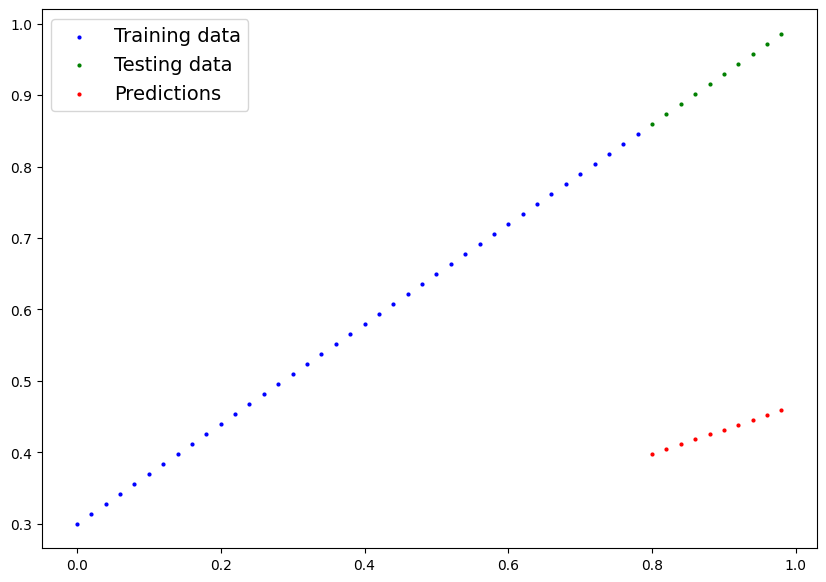

In [243]:
plot_predictions(predictions=y_preds)

#### Setting up loss function and the optimizer

In [244]:
# Setup the loss
loss_fn = nn.L1Loss()

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [245]:
loss_fn

L1Loss()

In [246]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

#### Build a training loop

In [247]:
torch.manual_seed(42)
# define the number of epochs (1 epoch = 1 loop through data)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

# loop through the data
for epoch in range(epochs):
  # Set the model to training
  model_0.train()

  # 1 forward pass
  y_pred = model_0(X_train)

  # 2 calculate the loss
  loss = loss_fn(y_pred, y_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # performe backprop
  loss.backward()

  # Step the optimizer(gradient descent)
  optimizer.step()


  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_pred = model_0(X_test)
    # Calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:

    epoch_count.append(epoch)
    loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())

    print(f'Epoch: {epoch} | Loss: {loss} | Test_loss: {test_loss}')


  # # print out model state dict
  # if(epoch%10 == 0):
  #   print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test_loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test_loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test_loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test_loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test_loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test_loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test_loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test_loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test_loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test_loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test_loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test_loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test_loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test_loss: 0.03233227878808975
Ep

In [248]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

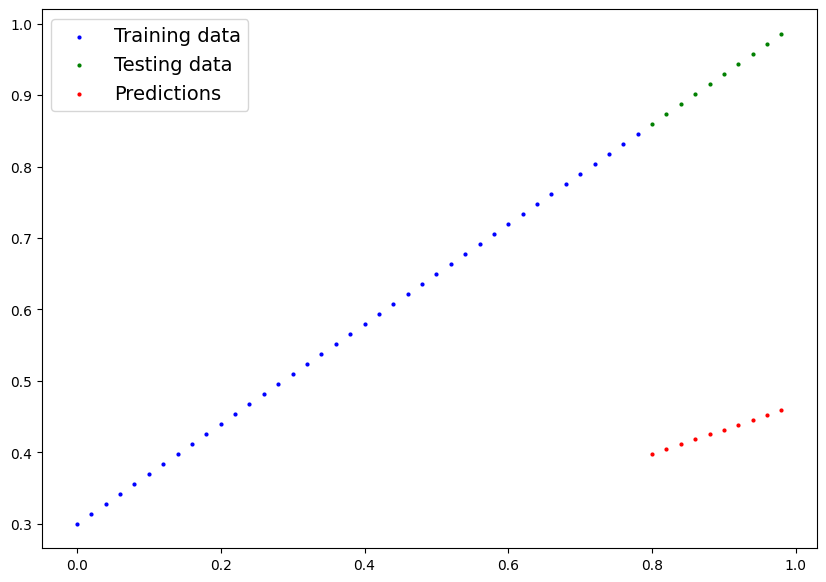

In [249]:
plot_predictions(predictions=y_preds)

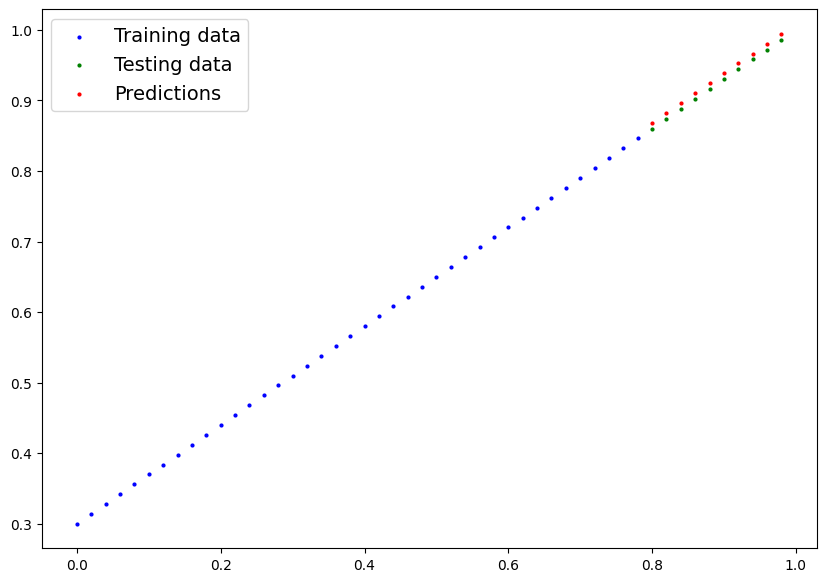

In [250]:
plot_predictions(predictions=y_preds_new)

In [251]:
epoch_count

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190]

In [252]:
loss_values

[0.31288138031959534,
 0.1976713240146637,
 0.08908725529909134,
 0.053148526698350906,
 0.04543796554207802,
 0.04167863354086876,
 0.03818932920694351,
 0.03476089984178543,
 0.03132382780313492,
 0.02788739837706089,
 0.024458957836031914,
 0.021020207554101944,
 0.01758546568453312,
 0.014155393466353416,
 0.010716589167714119,
 0.0072835334576666355,
 0.0038517764769494534,
 0.008932482451200485,
 0.008932482451200485,
 0.008932482451200485]

In [253]:
test_loss_values

[0.48106518387794495,
 0.3463551998138428,
 0.21729660034179688,
 0.14464017748832703,
 0.11360953003168106,
 0.09919948130846024,
 0.08886633068323135,
 0.0805937647819519,
 0.07232122868299484,
 0.06473556160926819,
 0.05646304413676262,
 0.04819049686193466,
 0.04060482233762741,
 0.03233227878808975,
 0.024059748277068138,
 0.016474086791276932,
 0.008201557211577892,
 0.005023092031478882,
 0.005023092031478882,
 0.005023092031478882]

#### Plot the loss curves

In [254]:
# plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label='Train loss')
# plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).cpu().numpy()), label='Test Loss')
# plt.title("Loss Values")
# plt.ylabel("Loss")
# plt.xlabel("Epochs")
# plt.legend()

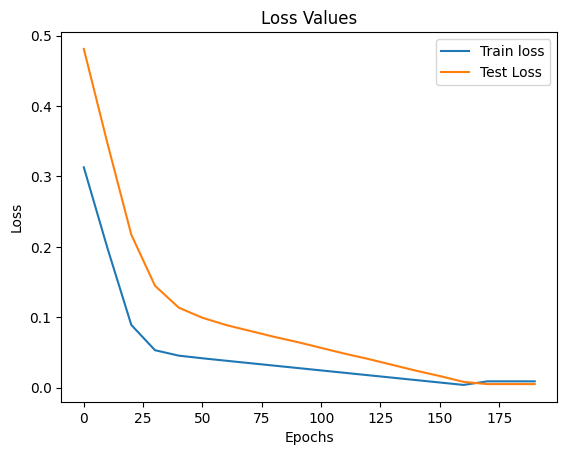

In [255]:
plt.plot(epoch_count, loss_values, label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')
plt.title("Loss Values")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Saving and loading the model

#### Saving the model

* 1. torch.save() -- allows us to save a Pytorch object in python pickle format
* 2. torch.load() -- allows us to load a saved object
* 3. torch.nn.Module.load_state_dict() -- this will load the models state dictionary

In [256]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [257]:
# Saving the state dict is the recommended way

In [258]:
from pathlib import Path

# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


# Model save path
MODEL_NAME = "01_first_model_regression.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the models state dict
print(f'Saving the model into: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving the model into: models/01_first_model_regression.pth


#### Load the model

In [259]:
loaded_model_0 = LinearRegressionModel()

In [260]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [261]:
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [262]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

#### Make some predictions using the loaded model

In [265]:
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [266]:
# Compare original preds with loaded preds

y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Put everything togather

#### Import libraries

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
print(torch.__version__)

2.2.1+cu121


#### Create the device agnostic code

In [2]:
!nvidia-smi

Tue Apr 16 00:21:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Create the data

In [4]:
# Create data using linear regression formula y = mx + c
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [5]:
X[:5]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])

In [6]:
y[:5]

tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])

#### Split the data

In [7]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [8]:
len(X_test), len(y_test), len(X_train), len(y_train)

(10, 10, 40, 40)

#### Plot the data

In [9]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
    Plot training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  # plot training data
  plt.scatter(train_data, train_labels, c='r', s=4, label='Training data')

  # Plot test data
  plt.scatter(test_data, test_labels, c='b', s=4, label='Testing data')

  # are there predictions
  if predictions is not None:

    # plot the predictions if they exists
    plt.scatter(test_data, predictions, c='g', s=4, label='Predictions')

  plt.legend(prop={'size': 14});

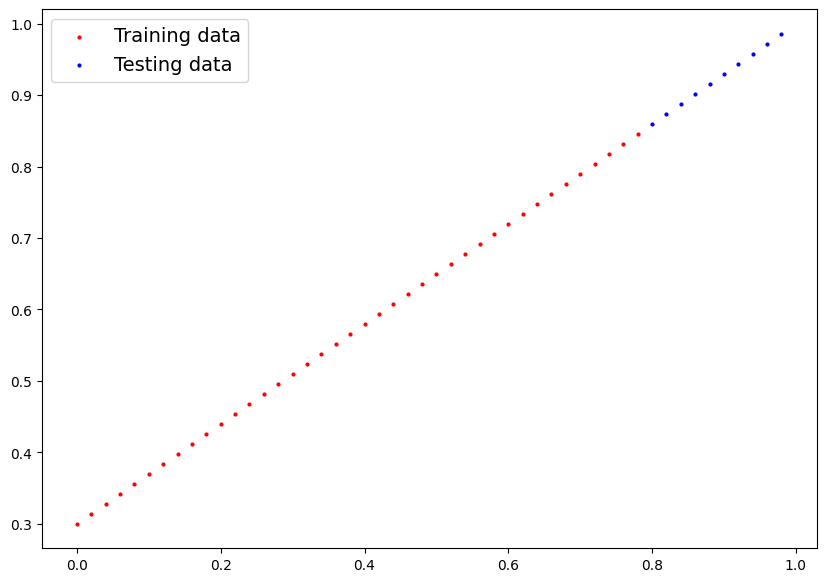

In [10]:
plot_predictions()

#### Build a linear Model

In [23]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer1 = nn.Linear(in_features=1, out_features=1)


  def forward(self, x : torch.Tensor) -> torch.Tensor:
    z = self.linear_layer1(x)
    return z

torch.manual_seed(42)
model_v2 = LinearRegressionModelV2()
model_v2, model_v2.state_dict()

(LinearRegressionModelV2(
   (linear_layer1): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer1.weight', tensor([[0.7645]])),
              ('linear_layer1.bias', tensor([0.8300]))]))

#### Send the model to the GPU

In [24]:
next(model_v2.parameters()).device

device(type='cpu')

In [25]:
model_v2.to(device)
next(model_v2.parameters()).device

device(type='cuda', index=0)

#### Setting up the loss function and the optimizer

In [26]:
# Loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params=model_v2.parameters(), lr=0.01)

#### Put the data into the GPU

In [27]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

#### Training loop

In [28]:
torch.manual_seed(42)

epochs_count = []
test_loss_count = []
loss_count = []

epochs = 200

for epoch in range(epochs):
  # put the model to training
  model_v2.train()
  epochs_count.append(epoch)
  # Forward pass
  y_pred = model_v2(X_train)

  # calculate the loss
  loss = loss_fn(y_pred, y_train)
  loss_count.append(loss.item())

  # optimizer zero grad, backprop and step
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # send the model to testing
  model_v2.eval()
  with torch.inference_mode():
    test_pred = model_v2(X_test)

    # Calculat the test loss
    test_loss = loss_fn(test_pred, y_test)
    test_loss_count.append(test_loss.item())

  # Print what happening
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Train_Loss: {loss} | Test_Loss: {test_loss}')

Epoch: 0 | Train_Loss: 0.5551779866218567 | Test_Loss: 0.5739762187004089
Epoch: 10 | Train_Loss: 0.439968079328537 | Test_Loss: 0.4392664134502411
Epoch: 20 | Train_Loss: 0.3247582018375397 | Test_Loss: 0.30455657839775085
Epoch: 30 | Train_Loss: 0.20954833924770355 | Test_Loss: 0.16984669864177704
Epoch: 40 | Train_Loss: 0.09433845430612564 | Test_Loss: 0.03513690456748009
Epoch: 50 | Train_Loss: 0.023886388167738914 | Test_Loss: 0.04784907028079033
Epoch: 60 | Train_Loss: 0.019956795498728752 | Test_Loss: 0.045803118497133255
Epoch: 70 | Train_Loss: 0.016517987474799156 | Test_Loss: 0.037530567497015
Epoch: 80 | Train_Loss: 0.013089174404740334 | Test_Loss: 0.02994490973651409
Epoch: 90 | Train_Loss: 0.009653178043663502 | Test_Loss: 0.02167237363755703
Epoch: 100 | Train_Loss: 0.006215683650225401 | Test_Loss: 0.014086711220443249
Epoch: 110 | Train_Loss: 0.00278724217787385 | Test_Loss: 0.005814164876937866
Epoch: 120 | Train_Loss: 0.0012645035749301314 | Test_Loss: 0.013801801018

In [29]:
model_v2.state_dict()

OrderedDict([('linear_layer1.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer1.bias', tensor([0.3025], device='cuda:0'))])

In [30]:
weight, bias

(0.7, 0.3)

#### Make predictions

In [31]:
model_v2.eval()

with torch.inference_mode():
  y_preds = model_v2(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

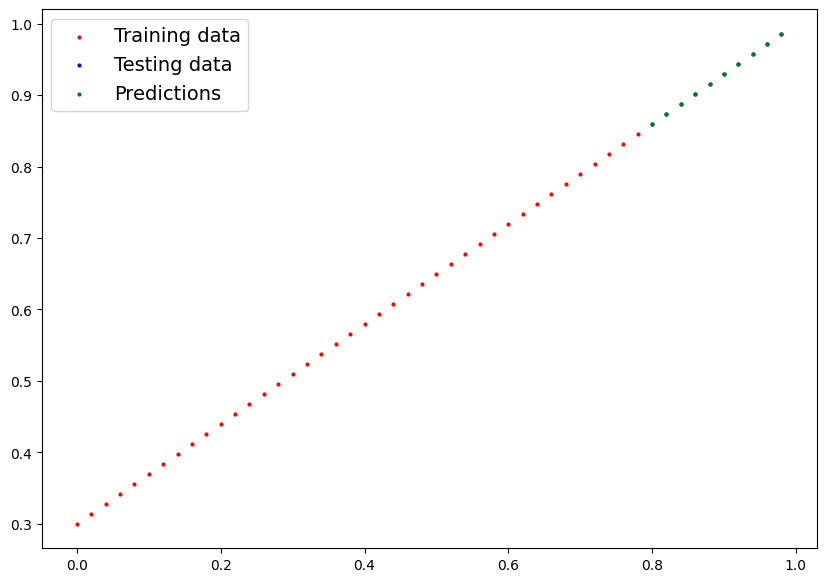

In [32]:
plot_predictions(predictions=y_preds.to('cpu'))

#### Save the model

In [34]:
from pathlib import Path

# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


# Model save path
MODEL_NAME = "all_togather_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the models state dict
print(f'Saving the model into: {MODEL_SAVE_PATH}')
torch.save(obj=model_v2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving the model into: models/all_togather_model.pth


#### Load the model

In [35]:
loaded_model_v2 = LinearRegressionModelV2()

loaded_model_v2.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [36]:
loaded_model_v2.to(device)

LinearRegressionModelV2(
  (linear_layer1): Linear(in_features=1, out_features=1, bias=True)
)

In [37]:
loaded_model_v2.state_dict()

OrderedDict([('linear_layer1.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer1.bias', tensor([0.3025], device='cuda:0'))])

In [38]:
next(loaded_model_v2.parameters()).device

device(type='cuda', index=0)